# Teach Your Laptop to Trade Stock Options.
# Notebook 5: Peek Inside the Black Boxes.
01/04/2021
Often nachine learners act like black boxes, even magic. We collect "eye of newt, toe of frog, " call them features, throw them into a black cauldron (dataframe), mutter some Python incantations, then out pops the answer. It is no surprise that business execs and leaders often resist using these magical solutions. 

If you want your ML solutions to be used in practice, you may need to develop some understanding of how a Learner uses the features, as well as the math underlying each Learner. Then you can demystify the solution for the folks who may have to make significant bets, in reputation and dollars, on using your solutions.

I confess, sometimes it does feel like magic to me. While I understand how a gradient descent algorithm works, executing it over hundreds or even thousands of features in a few seconds is tuly amazing.


## Purpose of this Notebook - Explore Feature Importance. 
Understand How the Learners Use Features.
This notebook is the fourth in a series of notebooks that demonstrate how to train a Machine learner to trade stock options, successfully, we hope. This notebook demonstrates how to look inside the Learner "black boxes" to understand how each Learner evaluates the features. We want to know how important is each feature to the Learner's process. This is generally called feature importance, as opposed to the feature elimination and scaling, the tools we used prior to running the Lear

Feature importance is specificlly NOT an explanation of the mathematics and algorithm of the Learner. Feature importance is the relative impact each feature has on the output of the final model for the Learner. Feature importance can improve your feature engineering for future development. Also feature importance can give non-technical team leaders and decision makers some intuitive understanding of "how the Learner thinks," thus perhaps providing enough confidence to use the Learner in actual business usage.

This notebook uses a data set of stock option trades for ExxonMobil (XOM) from 2017-2018 to illustrate many aspects of Machine Learning with the python SKLearn library. All the trades are short covered calls. 

What You Need: Basic knowledge of Python, pandas, numpy, dataframes, and statistics. 

What You Don't Need: Knowledge of stock options, scipy, sklearn, or Machine Learning. This project is self-contained and you will learn as you go.

You will Learn:

- How to use the internal methods for several Learners to see their internal evaluation of feature importance. 
- How to use several external tools--Shapley, SHAP, and LIME--to display and evaluate feature importance.


## 1. Load the feature set and train the Learners.

These steps are covered in detail in notebook 3, so for this exercise we will not discuss in detail.



In [1]:
import pandas as pd
import numpy as np
training_features = pd.DataFrame()
training_features = pd.read_csv('training_features_wlabel.csv', index_col = False)


Unnamed: 0    label
['stock_price_at_STO_offer', 'STO_strike', 'STO_days_long', 'STO_offer_ARR', 'stock_price_at_open', 'STO_ask_fee%', 'STO_offer_strike_delta%', 'Closed_xtn_Profit$', 'Closed_xtn_Profit%', '45 day SMA', '30 day SMA', '15 day SMA', '10 day SMA', 'Yearly Min', 'Yearly Max', '1 days old', '2 days old', '3 days old', '4 days old', '5 days old', 'RSI', 'MFI', 'MACD', '45 day vel', '30 day vel', '15 day vel', '10 day vel', '5 day vel', '2 day vel', 'ER - Expiry']
30


## 2. Set up the Learner Function. 

In [2]:
# Import ML Libraries from SKLearn.

import lightgbm
from lightgbm import LGBMClassifier as LGBMC

from sklearn import svm
from sklearn import metrics

from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.datasets          import make_classification
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.naive_bayes       import GaussianNB 
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost                   import XGBClassifier
import catboost
from catboost                  import CatBoostClassifier
from sklearn.feature_selection import chi2

import time
import random

def RunLearners(Xr_train, Xr_test, yr_train, yr_test, all_run_stats, stats_columns, run_ID):
    print() 
    print('Please be patient. Some of these Learners are pretty slow learners.')
    print('If you get impatient, put in a print statement to show progress, or just use one already in place.')
    print()
    
    learners = {#'SVC sigmoid'      : svm.SVC(kernel = 'sigmoid'),
                #'SVC linear'       : svm.SVC(kernel = 'linear'),
                #'SVC poly'         : svm.SVC(kernel = 'poly'),
                #'GaussianNB'       : GaussianNB(),
                'MLPerceptron'     : MLPClassifier(alpha=1, max_iter=1000),
                'AdaBoost'         : AdaBoostClassifier(),
                #'RandomForest_d6'  : RandomForestClassifier(max_depth=3, random_state=97),
                #'KNNeighbors_2'    : KNeighborsClassifier(n_neighbors=3),
                'KNNeighbors_8'    : KNeighborsClassifier(n_neighbors=8),
                'GradientBoost'    : GradientBoostingClassifier(),
                'RandomForest_d12' : RandomForestClassifier(max_depth=12, random_state=97),
                'XGBoost'          : XGBClassifier(random_state = 97),
                'CatBoost'         : CatBoostClassifier(verbose = False, iterations = 300),
                'LightGBoost'      : LGBMC()
               }
    
    learner_types = learners.keys()
    for learner in learner_types: 
        print(learner ,'is learning now.')   
        clf = learners[learner]
        start_time = time.time()  
        clf.fit(Xr_train, yr_train)
        end_time = time.time()
        
        train_time = end_time - start_time
        start_time = time.time()  
        yr_pred = clf.predict(X_test)
        end_time = time.time()
        predict_time = end_time - start_time
        
        #Performance Metrics
        accuracy       = metrics.accuracy_score(yr_test, yr_pred)
        precision      = metrics.average_precision_score(yr_test, yr_pred)
        recall         = metrics.recall_score(yr_test, yr_pred, labels=None, pos_label=1, 
                                         average='binary', sample_weight=None, zero_division='warn')
        F1_score       = metrics.f1_score(yr_test, yr_pred, labels=None, pos_label=1, average='binary', 
                                     sample_weight=None, zero_division='warn')
        tn, fp, fn, tp = metrics.confusion_matrix(yr_test, yr_pred, labels=None, sample_weight=None, normalize=None).ravel()
        mcc            = metrics.matthews_corrcoef(yr_test, yr_pred, sample_weight=None)
        
        learner_metrics_dict = {'Learner'  : [learner],
                                'Accuracy' : [accuracy],
                                'Precision': [precision], 
                                'Recall'   : [recall],
                                'MCC'      : [mcc],
                                'True Neg' : [tn],
                                'False Pos': [fp], 
                                'False Neg': [fn], 
                                'True Pos' : [tp],
                                'Train Time': [train_time],
                                'Predict Time': [predict_time], 
                                'Run_ID'      : [run_ID]
                               }
                
        this_run_stats = pd.DataFrame(data = learner_metrics_dict)         
        all_run_stats = all_run_stats.append(this_run_stats)
    return all_run_stats

print()
print('No output yet. Call this function with a set of train and test features.')



No output yet. Call this function with a set of train and test features.


In [3]:
# Prepare the test and train data sets.

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test  = pd.DataFrame()
y_test  = pd.DataFrame()

stats_columns = ['Learner', 'Accuracy', 'Precision', 'Recall', 'MCC',
                 'True Neg', 'False Neg', 'True Pos', 'False Pos', 'Train Time', 'Predict Time', 'Run_ID']

learner_stats = pd.DataFrame(columns = stats_columns)

X_train  = pd.read_csv('opt_sample.csv', index_col = 0)

y_train = X_train[['label']].to_numpy()
y_train = y_train.ravel()
print('y_train shape = ', y_train.shape)
X_train.drop(labels = 'label', axis = 'columns', inplace = True)
print('X_train shape = ', X_train.shape)

X_test = pd.read_csv('opt_test.csv', index_col = 0)
y_test = X_test[['label']].to_numpy()
X_test.drop(labels = 'label', axis = 'columns', inplace = True)

y_train = np.ravel(y_train)
y_test  = np.ravel(y_test)

run_ID = 'Initial'

learner_stats = RunLearners(X_train, X_test, y_train, y_test, learner_stats, stats_columns, run_ID)
learner_stats['sample count'] = learner_stats['True Neg']  + learner_stats['True Pos'] + \
                                learner_stats['False Neg'] + learner_stats['False Pos']
print()
print(learner_stats)
learner_stats.to_csv('learner_stats.csv')

y_train shape =  (5577,)
X_train shape =  (5577, 28)

Please be patient. Some of these Learners are pretty slow learners.
If you get impatient, put in a print statement to show progress, or just use one already in place.

MLPerceptron is learning now.
AdaBoost is learning now.
KNNeighbors_8 is learning now.
GradientBoost is learning now.
RandomForest_d12 is learning now.
XGBoost is learning now.
CatBoost is learning now.
LightGBoost is learning now.

            Learner  Accuracy  Precision    Recall       MCC True Neg  \
0      MLPerceptron  0.845686   0.777343  0.781818  0.689384      884   
0          AdaBoost  0.892699   0.834792  0.872727  0.783534      894   
0     KNNeighbors_8  0.923119   0.881792  0.900606  0.845007      926   
0     GradientBoost  0.961283   0.938148  0.952727  0.921946      952   
0  RandomForest_d12  0.965708   0.946245  0.955152  0.930891      958   
0           XGBoost  0.991704   0.985255  0.992727  0.983290      974   
0          CatBoost  0.991150   0.

## 6. Plot and Compare Performance of the Learners.



<AxesSubplot:>

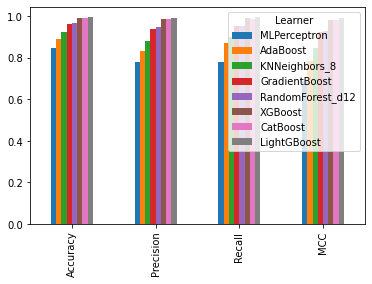

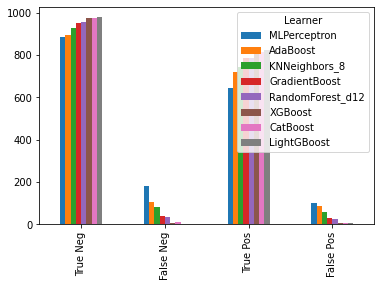

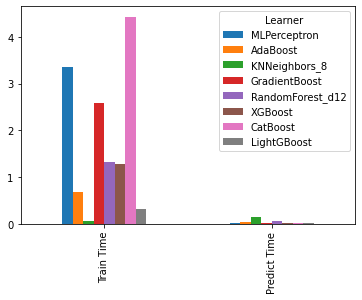

In [4]:

stats_for_plot = learner_stats.set_index('Learner', inplace=False, verify_integrity=False)
stats_xp = stats_for_plot.transpose(copy = True)
drop_rows = ['True Neg', 'False Pos', 'False Neg', 'True Pos', 'Train Time', 'Predict Time', 'Run_ID', 'sample count']
metrics = stats_xp.drop(labels = drop_rows, axis = 0, inplace = False)
metrics.plot.bar()

drop_rows = ['Accuracy', 'Precision', 'Recall', 'MCC','Train Time', 'Predict Time', 'Run_ID', 'sample count']
confusion = stats_xp.drop(labels = drop_rows, axis = 0, inplace = False)
confusion.plot.bar()

drop_rows = ['Accuracy', 'Precision', 'Recall', 'MCC', 'True Neg', 'False Pos', 'False Neg', \
             'True Pos', 'Run_ID', 'sample count']
speed = stats_xp.drop(labels = drop_rows, axis = 0, inplace = False)
speed.plot.bar()



## Feature Importance - Many Metrics
Machine Learning is often accused of being a black box. While this may be a valid criticism,many Learners have built-in methods to present their internal metrics for features, sort of like human insights into what they learned. In this section we will use some methods for several Learners to understand how they actually used the features to get such impressive results. 

Read the code, run the code, then consider the questions following the code block.

28


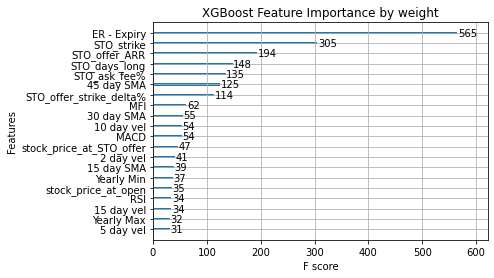

[16 25 26 22 21 14  5 19  2  0 15  3 10 17 24 11  1 20 13 27 18  4 12  6
 23  7  9  8]
[0.00173445 0.00443445 0.00506575 0.00507439 0.00669582 0.0081165
 0.00971207 0.01096211 0.01124433 0.01535338 0.01570486 0.02193252
 0.02225249 0.02266646 0.0231451  0.02549643 0.02625801 0.02860232
 0.03408044 0.03507316 0.04121375 0.04287151 0.04548754 0.05754117
 0.05957359 0.06982789 0.11352307 0.2363565 ]


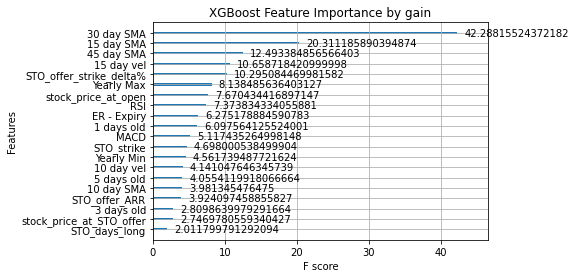

[16 25 26 22 21 14  5 19  2  0 15  3 10 17 24 11  1 20 13 27 18  4 12  6
 23  7  9  8]
[0.00173445 0.00443445 0.00506575 0.00507439 0.00669582 0.0081165
 0.00971207 0.01096211 0.01124433 0.01535338 0.01570486 0.02193252
 0.02225249 0.02266646 0.0231451  0.02549643 0.02625801 0.02860232
 0.03408044 0.03507316 0.04121375 0.04287151 0.04548754 0.05754117
 0.05957359 0.06982789 0.11352307 0.2363565 ]


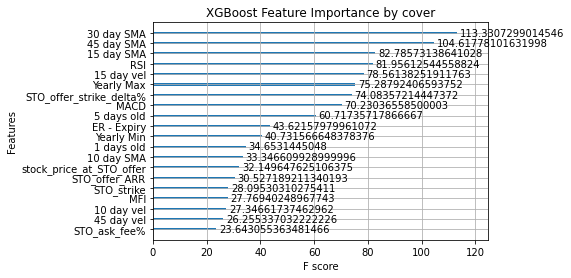

[16 25 26 22 21 14  5 19  2  0 15  3 10 17 24 11  1 20 13 27 18  4 12  6
 23  7  9  8]
[0.00173445 0.00443445 0.00506575 0.00507439 0.00669582 0.0081165
 0.00971207 0.01096211 0.01124433 0.01535338 0.01570486 0.02193252
 0.02225249 0.02266646 0.0231451  0.02549643 0.02625801 0.02860232
 0.03408044 0.03507316 0.04121375 0.04287151 0.04548754 0.05754117
 0.05957359 0.06982789 0.11352307 0.2363565 ]


In [19]:
import matplotlib
import matplotlib.pyplot as plt

xgb_fscores = pd.DataFrame()
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
feature_names = xgb_model.get_booster().feature_names
print(len(feature_names))

#model_file_name = 'xgbc_model.json'
#xgboost.Booster.dump_model(model_file_name)

importance_types = ['weight', 'gain', 'cover']
for importance_metric in importance_types:
    xgboost.plot_importance(xgb_model, importance_type = importance_metric, max_num_features = 20)
    plot_title = 'XGBoost Feature Importance by '+ importance_metric
    plt.title(plot_title)
    plt.show()
    scores = xgb_model.feature_importances_

    
    sorted_index = xgb_model.feature_importances_.argsort()
    print(sorted_index)
    print(xgb_model.feature_importances_[sorted_index])
#    print(feature_names[sorted_index])
#plt.barh(boston.feature_names[sorted_idx], xgb.feature_importances_[sorted_idx])
#    plt.barh(xgb_model.feature_importances_[sorted_index])

The charts show features scores and rankings based on internal mesurements by XGBoost for weight, gain, and cover. 

Weight is the number of times the feature was used to split.
Gain is the information gain (decrease in entropy) as a result of each split.
Cover is the number or percent of samples to which the rule applies (covers).

These metrics are not mutually exclusive. In fact, their interrelatinoships are very rich. Consider the feature ER-Expiry, which ranked 1 (most important) in weight, 9 in gain, and 10 in cover. Without diving into the details of ER-Expiry, describe the characteristics of a feature which would exhibit this behavior. It must be used in many splits, but contribute only an average gain, and cover only an average number of samples. So this type of feature must be powerful primarily in conjunction with other features. 

Consider the SMA features: 30 day SMA, 15 day SMA, and 45 day SMA. They ranked 1, 2, and 3 in gain and cover, but dropped to 9, 14, and 6 in weight. This pattern is just the opposite of the ranking for feature ER-Expiry. What characteristics do these features have in common?

Evaluation Questions - Understand the Model, er, Forest
Use sklearn methods to interrogate the model to answer these questions. 
- How many trees in this forest?
- How many rules in this forest?
- How many decision notes? Leaf nodes?

Evaluation Questions - Understand the metrics.
- What are the three metrics? Define each metric in your own words.
- In the units shown in the charts, what is the maximum value for weight, gain, and cover.
- Describe the characteristics of a feature that scores high on one metric and low on the other two.
- Give an example of a tree where a feature scores high / low on each metric.
- Can a single feature score high on all three metrics simultaneously? Why, or not?
- Why are these metrics so important for random forests?

Code Questions
- The numbers in the lower two charts are not formatted well. Please fix.
- How would you use all these metrics to prune the feature set? Now write the code.
- Run all the learners with your reduced feature set. Any performance differences? Why, or not?
    

## Shapley Additive Values
Shapley value is a weighted average of the marginal contributions of a featrure value to the prediction in different coalitions (combinations) of features.

Shapley value is NOT a change in the prediciton when the feature is removed.

Shapley value has exhibits critical characteristics:
-Efficiency - feature contributions must sum to:
        delta(pred(x)) - average(predictions).
-Symmetry - If feature values i and j contribute equally to all possible coalitions, then Shapley value (i) = Shapley value (j).
-Dummy - If feature j contributes 0 to the prediction (no change in the prediction), then its Shapley value must be = 0.
-Additivity - for the payouts value + value*, Shapley value = x(j) + x(j*)

Problem with Shapley is a computational explosion--2^k coalitions.   

## Congratulations, you peeked inside the Learners with a real data set.

Congratulations! You just trained several Learners to pick winning stock option trades. Now, you are almost ready to make a fortune in the stock market. But, first... consider these questions:

- How can you improve the feature set? 
- Which Learner(s) would you choose? Why?
- How can you gain more confidence in your trader?
- What is your goal? Single profitable trades, or a portfolio of trades? What's the difference?

Tune into the next exciting notebook to explore questions of maximizing portfolio results for options trading. 

Wishing you only profitable trades and good learning,

Richard Barrett

richard at rbshomes dot com.

P.S. I want to hear about your adventures in Machine Learning, your questions and comments about stock option trading, and especially your specific applications for machine learning. Just shoot me an email.
